In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")
#sns.set_context("poster")

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# For this exercise you need to install yellowbrick
# it will be also useful to take a look at the documentation
#    scikit-yb.org
#
# ! pip install yellowbrick

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import preprocessing

from sklearn.datasets import load_wine
from sklearn.datasets import load_boston

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.model_selection import LearningCurve


<h1>Clustering</h1>

Clustering is the most common and well-known unsupervised learning techniques. We can find clustring almost everywhere, in political campaigns, in client segmentation, ... The aglomeration of similar items is very familiar to us, Cities are clusters of people and in cities business traditionally cluster.

However, the fact that clustering is unsupervised poses some problems to validation metrics and verification. There is normally no grown truth, therefore there is not a single solution. Many times clusters, including its number, depends on the point of view of the problem and the questions that we are trying to address. 

The first problem that we encounter with clustering is finding out the best number of clusters. For this the elbow method is commonly used. It performs k-means with an increasingly number of clusters finding the k (number of clusters) that minimizes intra-cluster distance.

Checking the goodness is commonly done using the Silhoutte coefficient that measures the mean intra-cluster distance relative to the nearest clusters providing an appreciation of compactness. 

Clustering is very intuitive in two-dimensional spaces, but difficult to imagine in multidimensional spaces. The output of a clustering algorithm are centroids which consists of vectors with the center for each attribute. Using predict we can easily assign membership. 

Also we aware that clustering works measuring distances, therefore we need to rescaled (normally between 0..1) all the attributes. 

In this notebook we will use the UCI wine dataset, a compilation of characteristics of 178 Italian red wines divided in three families. We will see how well clustering can find without any example these three classes. 

In many cases, like this one, clustering has some coincidences with classification. This is precisely this case. When this happens we know the ground truth and therefore we can apply measures such as accuracy. However, this is uncommon, and therefore assessing its goodness is difficult. 

This notebook heavily uses the yellowbrick library, please install it with 
<p style="margin-left: 200px"> <b><i>pip install yellowbrick</i></b> </p>

<img src="wine-dataset.jpg">

In [3]:
# We use the wine dataset
wine = load_wine()

print(wine["DESCR"])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,TARGET
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,TARGET
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


,alcohol
TARGET,
0,59
1,71
2,48


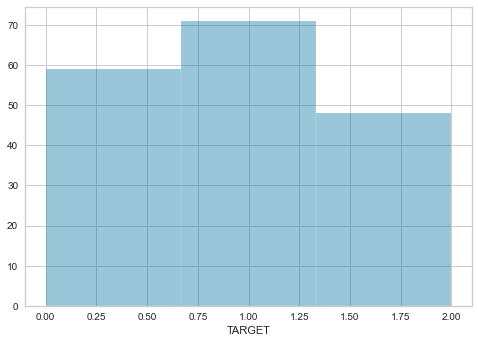

In [4]:
wine_df = pd.DataFrame(wine.data, columns=wine.feature_names)
wine_df['TARGET'] = wine.target
wine_df.head()

wine_df.describe()

wine_df[["TARGET", "alcohol"]].groupby("TARGET").count()

sns.distplot(wine_df["TARGET"],bins=3, kde=False)

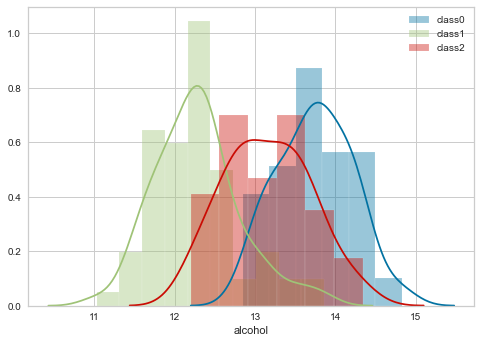

In [5]:
# let's plot the alcohol percentage for each class of wine

for i in wine_df["TARGET"].unique():
    sns.distplot(wine_df["alcohol"][wine_df["TARGET"]==i], label=f'class{i:d}')
plt.legend()

In [6]:
# Kmeans relies in a distance metric, therefore we need to rescale all features to the same scale 

X = wine_df.drop(['TARGET'], axis=1)
y = wine_df['TARGET']

min_max_scaler = preprocessing.MinMaxScaler()  # by default between 0 and 1

x_scaled_fit = min_max_scaler.fit(X)

x_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(x_scaled,columns=X.columns)
X_scaled.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


<Figure size 864x648 with 0 Axes>

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

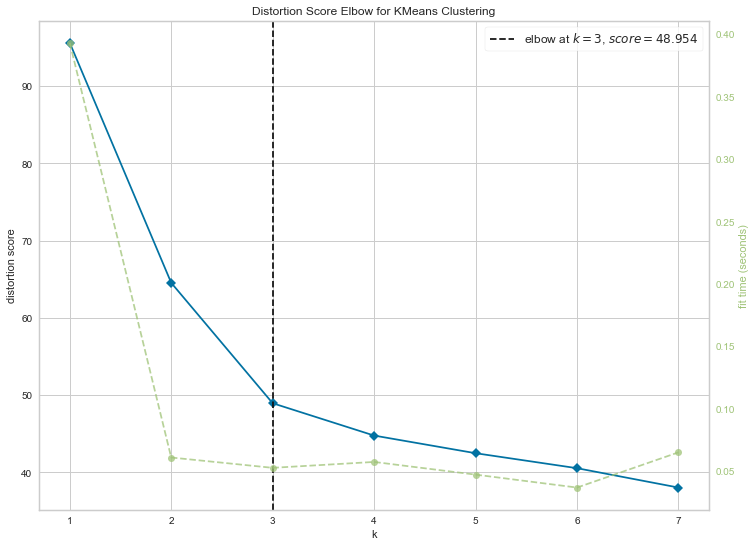

In [7]:
# Elbow method

min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(X)
X_scaled = pd.DataFrame(x_scaled,columns=X.columns)

plt.figure(figsize=(12,9))

# Now we apply KMeans
model = KMeans()

# we want first to find out how many clusters using the elbow technique
visualizer = KElbowVisualizer(model, k=(1,8))
visualizer.fit(X_scaled)      
visualizer.show()

# we know that there are 3 wine types (target=[0,1,2]) 
# and the elbow method correctely chooses 3

<Figure size 864x648 with 0 Axes>

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  f"MiniBatchKMeans is known to have a memory leak on "


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002C84C1FED88>,
                     colors='yellowbrick',
                     estimator=MiniBatchKMeans(n_clusters=3))

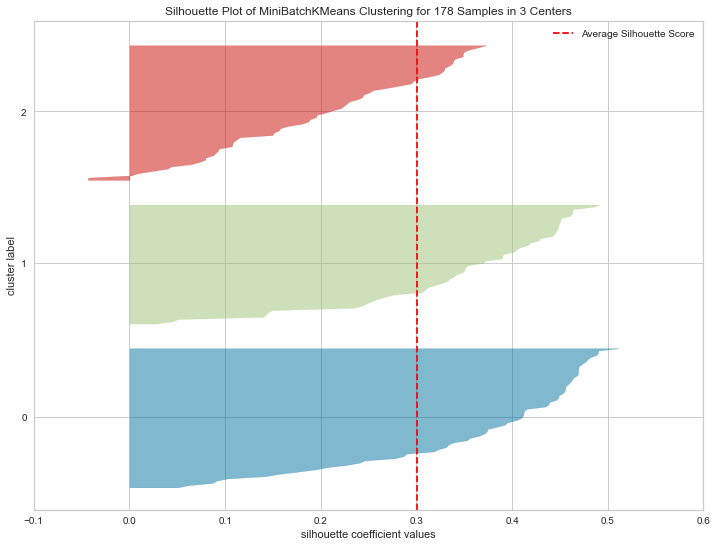

In [8]:
# Now we use Silhoutte to visualize the compactness of the clusters

plt.figure(figsize=(12,9))

#model = KMeans(3)
#model=MiniBatchKMeans(n_clusters=3, verbose=True).fit(X_scaled)

model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)

visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_scaled)      
visualizer.show()

<Figure size 864x648 with 0 Axes>

InterclusterDistance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002C84BF929C8>,
                     estimator=MiniBatchKMeans(n_clusters=3), min_size=10000)

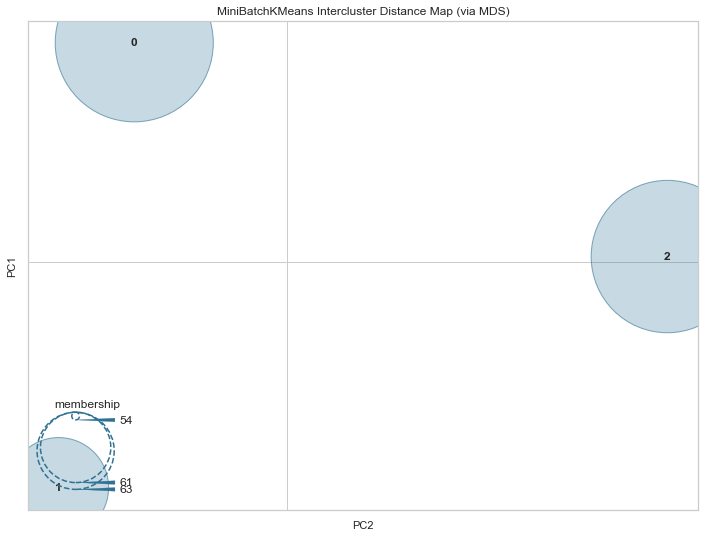

In [9]:
# Inter cluster distance 

plt.figure(figsize=(12,9))

#model=MiniBatchKMeans(n_clusters=3).fit(X_scaled)

visualizer = InterclusterDistance(model, min_size=10000)
#visualizer = InterclusterDistance(model)
visualizer.fit(X_scaled)
visualizer.show()

<Figure size 864x648 with 0 Axes>

TypeError: '<' not supported between instances of 'str' and 'int'

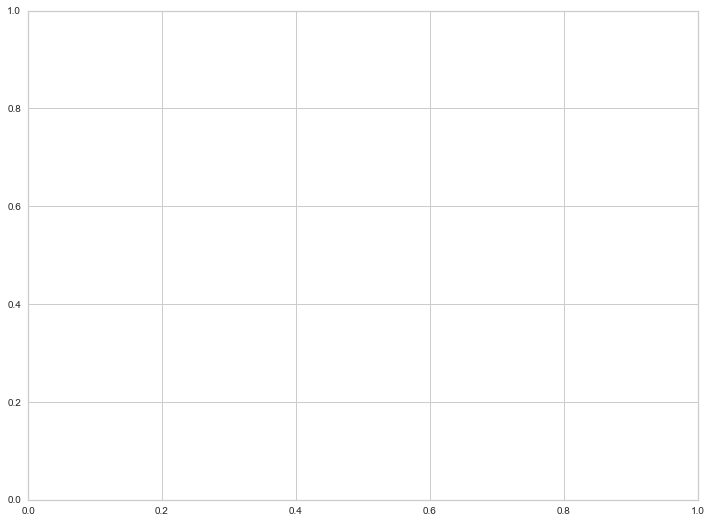

In [10]:
# Learning Curve

plt.figure(figsize=(12,9))

model = KMeans()

visualizer = LearningCurve(model, scoring="adjusted_rand_score")

visualizer.fit(X_scaled, y)        # Fit the data to the visualizer
visualizer.show()                  # Finalize and render the figure

In [ ]:
# Can we calculate accuracy ???

model=KMeans(3)
model=MiniBatchKMeans(n_clusters=3)

model.fit(X_scaled)

print("Predicted labels ----")
print(model.predict(X_scaled))
print()
print("Actual    labels ----")
print(y.values)
print()

print(" ---- Watch the labels ----")

acc_score=accuracy_score(y.values,model.predict(X_scaled))
print(f'Accuracy {acc_score*100:.3f}')


<h3>Silhouette score</h3>

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 

The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. 

If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
<p style="margin-left:200px"><b>
    a : mean distance between a sample and all other points in the same class. <br>
    b : mean distance between a sample and all other points in the next nearest cluster.
</b></p>
<br>
<p><b>
$$\large{s=\frac{b-a}{max(a,b}}$$
</b></p>

In [ ]:
# Silhouette score

from sklearn import metrics

she=metrics.silhouette_score(X_scaled, model.labels_, metric="euclidean")
print(f'Silhouette score {she:5f}')

In [ ]:
# Centroids

model.labels_
model.cluster_centers_

pd.DataFrame(model.cluster_centers_, columns=X.columns)

# BECAUSE WE SCALED WE HAVE TO BRING IT BACK TO THE ORIGINAL RANGES

pd.DataFrame(x_scaled_fit.inverse_transform(model.cluster_centers_),columns=X.columns)

# --- Now with these values we can have an interpretation of what each cluster means ---

<h1>Agglomerative Hierarchical Clustering</h1>

Agglomerative hierarchical clustering differs from k-means in a key way. 
Rather than choosing a number of clusters and starting out with random centroids, we instead begin 
with every point in our dataset as a “cluster.” Then we  nd the two closest points and combine them into a cluster. 
Then, we  nd the next closest points, and those become a cluster. 

We repeat the process until we only have one big giant cluster.

<img src="dendrogram.png">

In [ ]:
 # import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

plt.figure(figsize=(17,9))

# create dendrogram
dn = sch.dendrogram(sch.linkage(X_scaled, method='ward'), no_labels=True)
plt.show()

# create clusters
hc = AgglomerativeClustering(n_clusters=3, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart y_hc = hc.fit_predict(points)
print("predictions --- ")
y_hc = hc.fit_predict(X_scaled)
y_hc

print("labels --- ")
hc.labels_

print("pre-assigned labels --- ")
y.values

dk={0:2,1:0,2:1}
acc_score=accuracy_score(list(map(lambda x:dk[x],y.values)),hc.labels_)
print(f'Accuracy {acc_score*100:.3f}')


<b><font color="red" size=6>Mission 1</font>

a) Cluster Europe using the EUindicators dataset and explain the clusterization using the centroids.<br><br>
b) Same for the credit card dataset. 
<br><br>
</b>

In [13]:
# Function to get the number of centroids

def scale_x(data):
    
    # Drop null values from the data:
    
    data.dropna(inplace = True)

    # Separate x and y

    x = data.drop([data.columns[0]], axis = 1)

    # Scale x and create a dataframe with the info

    x_scaled = min_max_scaler.fit_transform(x)
    
    return x_scaled


# Function to get column names

def get_columns(data):
    
    # Drop null values from the data:
    
    data.dropna(inplace = True)

    # Separate x and y

    x = data.drop([data.columns[0]], axis = 1)
    
    return x.columns


# Function to determine number of centroids

def cluster_centroids(data, kmeans):
    
    data.dropna(inplace = True)

    # Separate x and y

    x = data.drop([data.columns[0]], axis = 1)

    x_scaled = scale_x(data)
    
    # Using kmeans, clusterize the data

    model = KMeans(kmeans)
    model.fit(x_scaled)

    # Bring the data back to the original ranges
    
    x_scaled_fit = min_max_scaler.fit(x)
    centroids_rev = pd.DataFrame(x_scaled_fit.inverse_transform(model.cluster_centers_), columns = get_columns(data))

    return centroids_rev


# Function to determine number of clusters to use

def elbow(data, n):
    
    x_scaled = scale_x(data)
    
    # Now we apply KMeans
    model = KMeans()

    # we want first to find out how many clusters using the elbow technique
    visualizer = KElbowVisualizer(model, k=(1,n))
    visualizer.fit(x_scaled)      
    visualizer.show()
    
    
# Function for silouette scores
    
def sil(data, clusters):
    
    x_scaled = scale_x(data)
    
    model = MiniBatchKMeans(n_clusters = clusters)
    
    model.fit(x_scaled)
    
    sil = metrics.silhouette_score(x_scaled, model.labels_, metric="euclidean")
    print(f'Silhouette score {sil:5f}')


In [ ]:
eu_data = pd.read_excel("EUIndicators-2014-2018.xlsx", engine = "openpyxl")

elbow(eu_data, 12)

sil(eu_data, 4)

cluster_centroids(eu_data, 4)

In [ ]:
print("The first group have the highest confidence about their current and prospective economic status.") 
print("Confidence is especially high in the service and retail sectors. Also, all confidence indicators are higher")
print("than for the other groups. Hence, we can presume this is group is the richest.")
print("")
print("The second group has the lowest overall confidence, especially in construction and the consumer sectors.")
print("It only has positive indicators in the retail and service sectors.")
print("")
print("The third has the second highest business confidence indicators (slightly positive), mostly due to high confidence")
print("in the retail and service sectors.")
print("")
print("The last group has the third lowest confidence, very slightly below 0. Hence, the confidence in this group could be")
print("described as neutral. The sector with the highest confidence is the service sector.")


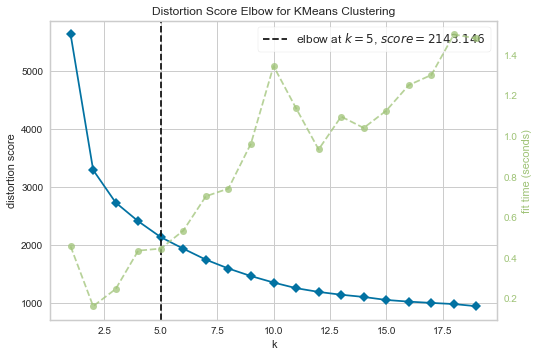

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  f"MiniBatchKMeans is known to have a memory leak on "


NameError: name 'metrics' is not defined

In [14]:
cc_data = pd.read_csv("CCData.csv")

elbow(cc_data, 20)

sil(cc_data, 5)

cluster_centroids(cc_data, 5)

In [ ]:
cc_data

In [ ]:
print("The first group has the lowest balance out of all the groups, and is the group with the lowest total purchases")
print("and frequency. However, they do get significant cash advances, even though its the second lowest amongst the groups.")
print("This group also has the lowest credit limit.")
print("")
print("The second group has the second highest balance, and the highest amount of purchases (and one-off purchases). The ")
print("group has also the highest amount of payments (since total purchases is the highest amount). The credit limit of")
print("this group is also the highest.")
print("")
print("This group has the highest balance of all the groups, but the lowest amount of total purchases and frequency. They") 
print("also ask for the highest amount of cash advances and cash advance frequency. The group makes the lowest amount of")
print("payments, and has an average credit limit")
print("")
print("The fourth group has an average balance, purchase total and credit limit. However, the group does have a high purchase")
print("frequency.")
print("")
print("The fifth group has a very low balance, very close to the lowest, but the second highest purchase total, as well as")
print("frequency, since the group also has the second highest credit limit.")


In [11]:
cc_data = pd.read_csv("CCData.csv")


In [12]:
cc_data

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6
